In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  5 11:35:25 2018

@author: wangying
"""

import os
import sys
import operator
import numpy as np
import pandas as pd
from sklearn import preprocessing
# from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
#from Part2_get_data import get_data
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict
from multiprocessing import Process, Lock, Manager
from sklearn.metrics import classification_report


In [3]:
global df1
global df2
#historical_data1_time_Q12006
col_names_svcg = ['loan_sequence_no', 'monthly_reporting_period', 'current_actual_upb', 'current_loan_delinquency_status',
                  'loan_age', 'remaning_months_on_legal_maturity', 'repurchase_flag', 'modification_flag', 'zero_bal_code',
                  'zero_bal_eff_date', 'current_interest_rate', 'current_deferred_upb', 'ddlpi', 'mi_recoveries', 'net_sales_proceeds',
                  'non_mi_recoveries', 'expenses', 'legal_costs', 'maintenance_preservation_cost', 'taxes_insurance', 'misc_expenses',
                  'actual_loss_calc', 'modification_cost']

df1 = pd.read_table('HistoricalInputFiles/historical_data1_time_Q12006.txt',
                    delimiter='|', names=col_names_svcg, index_col=None, nrows=200000, low_memory=False, usecols=list(np.arange(23)))
df2 = pd.read_table('HistoricalInputFiles/historical_data1_time_Q22006.txt',
                    delimiter='|', names=col_names_svcg, index_col=None, nrows=200000, low_memory=False, usecols=list(np.arange(23)))




In [4]:
df1.head()

,loan_sequence_no,monthly_reporting_period,current_actual_upb,current_loan_delinquency_status,loan_age,remaning_months_on_legal_maturity,repurchase_flag,modification_flag,zero_bal_code,zero_bal_eff_date,...,mi_recoveries,net_sales_proceeds,non_mi_recoveries,expenses,legal_costs,maintenance_preservation_cost,taxes_insurance,misc_expenses,actual_loss_calc,modification_cost
0,F106Q1000001,200603,130000.0,0,0,360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F106Q1000001,200604,130000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F106Q1000001,200605,130000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F106Q1000001,200606,130000.0,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F106Q1000001,200607,129000.0,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(col_names_svcg)

23

In [6]:
global X_train
global y_train
global X_test
global y_test
global matrix
global conf_mat_logred
global conf_mat_rf
global conf_mat_nn
global roc_auc_logred
global roc_auc_rf
global roc_auc_nn



In [7]:
def remove_nan(dff):
    dff.current_loan_delinquency_status = dff.current_loan_delinquency_status.replace('R', '1').astype('float64')

    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.replace(np.nan, 0)
    dff.remaning_months_on_legal_maturity = dff.remaning_months_on_legal_maturity.astype('category')

    dff.repurchase_flag = dff.repurchase_flag.replace(np.nan, 0)
    dff.repurchase_flag = dff.repurchase_flag.astype('category')

    dff.modification_flag = dff.modification_flag.replace(np.nan, 0)
    dff.modification_flag = dff.modification_flag.astype('category')

    dff.zero_bal_code = dff.zero_bal_code.replace(np.nan, 0)
    dff.zero_bal_code = dff.zero_bal_code.astype('category')

    dff.zero_bal_eff_date = dff.zero_bal_eff_date.replace(np.nan, 0)
    dff.zero_bal_eff_date = dff.zero_bal_eff_date.astype('category')

    dff.current_deferred_upb = dff.current_deferred_upb.replace(np.nan, 0)
    dff.current_deferred_upb = dff.current_deferred_upb.astype('category')

    dff.ddlpi = dff.ddlpi.replace(np.nan, 0)
    dff.ddlpi = dff.ddlpi.astype('category')

    dff.mi_recoveries = dff.mi_recoveries.replace(np.nan, 0)

    dff.net_sales_proceeds = dff.net_sales_proceeds.replace(np.nan, 0)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('C', 1)
    dff.net_sales_proceeds = dff.net_sales_proceeds.replace('U', 0)
    dff.net_sales_proceeds.astype('float64')

    dff.non_mi_recoveries = dff.non_mi_recoveries.replace(np.nan, 0)

    dff.expenses = dff.expenses.replace(np.nan, 0)

    dff.legal_costs = dff.legal_costs.replace(np.nan, 0)

    dff.maintenance_preservation_cost = dff.maintenance_preservation_cost.replace(np.nan, 0)
    dff.taxes_insurance = dff.taxes_insurance.replace(np.nan, 0)
    dff.misc_expenses = dff.misc_expenses.replace(np.nan, 0)
    dff.actual_loss_calc = dff.actual_loss_calc.replace(np.nan, 0)
    dff.modification_cost = dff.modification_cost.replace(np.nan, 0)

# remove null
remove_nan(df1)
remove_nan(df2)

In [8]:
# #### Processing the data, Change the numerical features to Dummy variables, Create the target variable,  Create Training and Testing datasets
def process_data():
    # Create target variable function
    def f(row):
        if row['current_loan_delinquency_status'] > 0:
            val = 1
        else:
            val = 0
        return val
    # Create dummy variables
    df1_dummies = pd.get_dummies(df1[['repurchase_flag', 'modification_flag']])
    df2_dummies = pd.get_dummies(df2[['repurchase_flag', 'modification_flag']])

    df1_d = df1.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)
    df2_d = df2.drop(['loan_sequence_no', 'repurchase_flag', 'modification_flag'], axis=1)

    global df1_final
    global df2_final
    df1_final = pd.concat([df1_d, df1_dummies], axis=1)
    df2_final = pd.concat([df2_d, df2_dummies], axis=1)

    # create target variable
    df1_final['Deliquent'] = df1_final.apply(f, axis=1)
    df2_final['Deliquent'] = df2_final.apply(f, axis=1)

    # Create training and testing set

    X_train = df1_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_train = df1_final['Deliquent']

    X_test = df2_final.drop(['current_loan_delinquency_status', 'Deliquent'], axis=1)
    y_test = df2_final['Deliquent']

    X_train = preprocessing.minmax_scale(np.array(X_train).astype(float))  # scale between 0 and 1
    X_test = preprocessing.minmax_scale(np.array(X_test).astype(float))

    return X_train, y_train, X_test, y_test


In [9]:
X_train, y_train, X_test, y_test = process_data()

In [10]:
'''----------------------------Logistic Regression---------------------------------------------------'''
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Fitting the Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, solver='lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [11]:
cm

array([[187064,    579],
       [ 11637,    720]])

[[177826   9817]
 [ 10084   2273]]


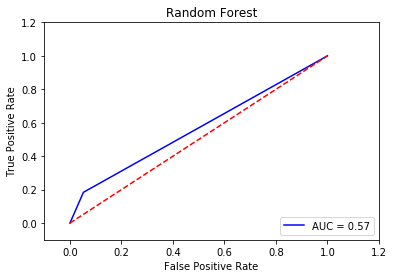

In [12]:
# random Forest
#def rf(X_train, y_train, X_test, y_test, return_dict_rf):
def rf(X_train, y_train, X_test, y_test):

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)

    conf_mat_rf = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_rf)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_rf = metrics.auc(false_positive_rate, true_positive_rate)
    #return_dict_rf['roc_auc_rf'] = roc_auc_rf
    #return_dict_rf['conf_mat_rf'] = conf_mat_rf

    # Plot ROC Curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_rf)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    

rf(X_train, y_train, X_test, y_test)

[[187064    579]
 [ 11637    720]]


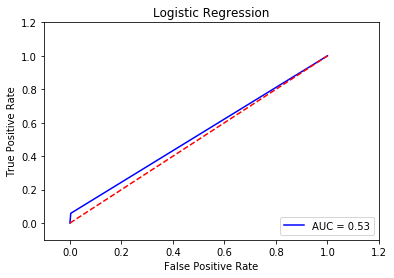

In [13]:
def logred(X_train, y_train, X_test, y_test):

    logreg = LogisticRegression(solver='lbfgs')
    logreg.fit(X_train, y_train)

    y_train_predicted = logreg.predict(X_train)
    y_test_predicted = logreg.predict(X_test)

    #print(metrics.classification_report(y_train, y_train_predicted))

    conf_mat_logred = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_logred)

    # Compute ROC curve and AUC (Area under the Curve)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)

    # Plot ROC Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_logred)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

logred(X_train, y_train, X_test, y_test)

[[  2661 184982]
 [     1  12356]]


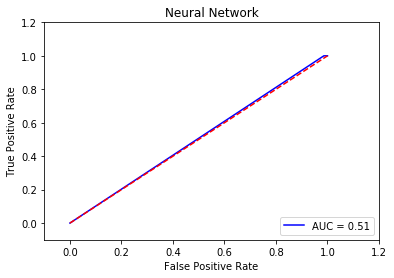

In [14]:
# ### Neural Network

def nn(X_train, y_train, X_test, y_test):

    nn = MLPClassifier()

    nn.fit(X_train, y_train)

    y_train_predicted = nn.predict(X_train)
    y_test_predicted = nn.predict(X_test)

    conf_mat_nn = metrics.confusion_matrix(y_test, y_test_predicted)
    print(conf_mat_nn)

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)

    roc_auc_nn = metrics.auc(false_positive_rate, true_positive_rate)

    # Plot ROC Curve
    plt.title("Neural Network")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = %0.2f' % roc_auc_nn)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

nn(X_train, y_train, X_test, y_test)